# Solving Minimum Set Cover problems

The Minimum Set Cover problem arises in several operational settings, such as
identifying:

  - the fewest number and location of depots that meet catchment
area or level of service requirements (see the example for Wellington below);
  - the cheapest set of staff that can complete a project where each sub-task requires different
    qualification standards and each staff member has a range of
    skills and costs (see my
    [code example here](https://gist.github.com/selwyn-mccracken/d8bddbffe4a68a599577)
    );
  - the lowest overall cost of project materials when suppliers have
    different rates for their combinations of materials.

According to [the Wikipedia definition:](https://en.wikipedia.org/wiki/Set_cover_problem)

  > "*Given a set of elements {1,2,...,m} (called the universe) and
	a set S of n sets whose union equals the universe, the set cover
	problem is to identify the smallest sub-collection of S whose union equals
	the universe.
    For example, consider the universe U = {1, 2, 3,
	4, 5} and the collection of sets S = {{1,2,3},{2, 4}, {3, 4}, {4,
	5}}. Clearly the union of S is U. However, we can cover all of
	the elements with the following, smaller number of sets: {{1,
	2, 3}, {4, 5}}.*"

To illustrate Set Cover solutions in practice, this article presents:

 1. Results from recent work to identify
the optimal number of emergency water hydrants for Wellington;
 2. A worked code example of airport coverage to show how you can implement these methods on
   your own projects.

![5 airport hubs](./5_airport_hubs.png)


## Wellington emergency hydrant locations

The city of Wellington [sits on a seismic fault](https://en.wikipedia.org/wiki/Wellington_Fault)
and MWH NZ has been working with Wellington Water to develop earthquake response
and forward works plans to maximise resilience.

One part of that project was to identify the optimal number and
location of emergency water hydrants that could supply the approximately
100,000 households in the greater Wellington region after a major earthquake. The primary
constraint supplied by the client was that 90% of households needed to
be within 1000 metres 'perceived' walking distance (i.e. steepness
adjusted) to their closest hydrant.

To validate the rather involved multi-person, multi-day, manual process used to choose sites, a fully automated
integer linear program was written in
[`Julia`](http://www.juliaopt.org/) to also solve this problem in **less
than 30 seconds** using a Set Cover algorithm. The primary input for both approaches was
the perceived walking distances of every household to each potential
hydrant location, based on a routable road network derived from
     [OpenStreetMap](http://www.openstreetmap.org/) and local terrain data.

Reasonable agreement was found between the number of sites chosen by the manual
(n=383) and algorithmic (n=334) selection processes, with the
difference of 49 sites largely due to additions made in the manual process (e.g. placing additional
hydrants near vulnerable populations such as geriatric rest homes). The catchment
areas of the algorithmically selected sites are
displayed as blue polygons in Figure 1 below, with unselected
locations that fall outside of the 90% coverage requirement coloured red.

The similarity of results from the set cover algorithm means that it can add significant
efficiencies to similar tasks in the future, either by quickly suggesting
candidate sites for manual evaluation or fully automating the
selection process if all the appropriate constraints are supplied as
inputs.


#### Figure 1. Number of households covered and catchment areas of algorithmically selected hydrant locations
![Coverage picture](proposed_wellington_emergency_hydrant_locations.png)

## Worked example: Service hub airport locations

To show how to implement Set Cover optimisation in practice, a
contrived example with associated code is presented below.

The example uses a
[small airport location dataset for New Zealand](https://koordinates.com/layer/123-nz-airport-polygons-topo-150k/),
 and given these airports, we want to
identify the best hub locations for flying distances of
200km and 700km. That is, what is the minimum number of
hub airports that can cover all airports for both of these flying ranges.

Optimal placement of flying doctor services could one be application
where calculations like these would be useful, where specialists
located at hubs need to quickly travel to locations of patients who
are too unwell to fly. Alternatively, hubs could be viewed as the
focal points of catchment areas, with specialist facilities located
centrally and the flying times of clients need to be kept below a level of
service threshold.

### Analysis steps
All of the code presented below is written in the
[`R` statistical programming language](http://r-project.org), with the
analysis completed in three steps:

1. Calculate the distances between all airports
2. Run the set cover optimisation, using `R` to execute an external [`Julia` script](Set_covering.jl)
3. Plot results


#### 1. Calculate distances between each airports

To identify the best set of locations requires that we know the
distance from each of the 52 named airports to all others. To
accomplish this,  the shapefile extracted xy coordinates are fed into
R's inbuilt `dist()` function, which returns the [Euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) between
all airports. The result is a 52x52 matrix of distances, commonly
called a "distance matrix". Note that we can use any distance
function we want, with the Euclidean distance chosen here simply for
convenience as it is sufficiently accurate the
[New Zealand Transverse Mercator (NZTM)](http://www.linz.govt.nz/data/geodetic-system/datums-projections-and-heights/projections/new-zealand-transverse-mercator-2000)
grid coordinates of our input data. Similar exercises with
inter-continental locations would probably
need
[Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance)
calculations. Likewise, direct-line Euclidean distances would be inappropriate
for road travel time estimates, which would require distances to be
derived from a network model that considers allowable routes.



In [1]:
#load necessary libraries
suppressWarnings(
    suppressMessages({
        library(sp)
        library(rgdal)
        library(leaflet)
        library(dplyr)
        library(ggplot2)
        library(maps)
        library(scales)
        library(repr)
    })
)

options(repr.plot.width=10, repr.plot.height=6)

#read airport polygons out of shapefile obtained from koordinates at:
#https://koordinates.com/layer/123-nz-airport-polygons-topo-150k/
nz_airports = readOGR('data/nz-airport-polygons-topo-150k','nz-airport-polygons-topo-150k')

#extract centroids (NZTM grid projection coordinates in metres)
#only keeping airports with names recorded in the file
coords = coordinates(nz_airports)[!is.na(nz_airports$name),]

#make a data.frame of coordinates to be used below
coords_df = data_frame(name = nz_airports$name[!is.na(nz_airports$name)] ,
                       easting = coords[,1],
                       northing = coords[,2])

#use dist function to calculate the Euclidean distance in metres between every airport
distances = dist(coords )

#convert to km from metres
distances = as.matrix(distances) / 1000


OGR data source with driver: ESRI Shapefile 
Source: "data/nz-airport-polygons-topo-150k", layer: "nz-airport-polygons-topo-150k"
with 61 features
It has 3 fields



#### 2. Run Set Cover optimisation
The Set Covering problem we are trying to solve
can be defined mathematically as follows:
$$
\begin{equation*}
\begin{array}{l@{}ll}
\text{minimize}  & \displaystyle\sum\limits_{i=1}^{m} x_{i} \\
\text{subject to}& Ax \geq \vec{1}  & \\
                 &x_{i} \in \{0,1\} &
\end{array}
\end{equation*}
$$

where x is a binary vector that represents whether an airport is
designated a hub or not and A is the binary distance matrix that has a
row for each airport with ones indicating which airports are within with
specified range. The matrix multiplication of Ax is the key set
covering constraint, and must produce a result vector where all of
the elements are greater than 1, meaning that all airports are
associated with at least one hub within range.

This definition was translated into an integer linear program
using the [JuMP library](http://www.juliaopt.org/) of the
[Julia language](http://julialang.org/), because I find the syntax
used by JuMP to be much easier to translate from the mathetical formulation than
alternatives in `R` or [`Python`](http://www.python.org). The 23 line `Set_covering.jl` program can be reviewed [here](Set_covering.jl).

To actually run the analysis, the R code below loops across the two flying ranges of interest (200 and
700km), and for each loop:

- creates a binary matrix of airports within that range, based on the
  distance matrix created above
- writes the binary matrix to a csv input file needed by `Set_covering.jl`
- executes `Set_covering.jl` with the current input file
- reads the csv results back in and annotates the data in preparation
for plotting.




In [2]:
ranges_of_interest = c(200,700) #km ranges - cherry pick 2 good examples

#loop through flying ranges and run set cover function
results = lapply(ranges_of_interest,function(rng){
  within_range = distances <= rng #create a boolean matrix if
  within_range_binary =  within_range  * 1 #multiply boolean matrix by 1 to output 1/0 values
  write.table(file='binary_array.csv',
              within_range_binary,
              row.names=FALSE,
              col.names=FALSE,sep=',')

  system('julia Set_covering.jl') #run the julia program

  sc_result = scan('set_cover_result.csv') #read back the results file

  #annotate the results
  coords_df %>%
    mutate(
      range = rng,
      hub_airport = sc_result == 1
    )

})

results = rbind_all(results) #join the resutls from each loop into a single dataframe




#### 3. Make Result plots
I make extensive use of R's excellent [ggplot2 library](http://ggplot2.org/) to produce
static charts, as it is powerful, flexible and the default output is
typically immediately production ready. Facetting is one feature of ggplot that I
really like, as it allows you to instantly produce identically formatted subplots
for each level of a categorical variable. For this example, I use
facets to make a subplot for each set of range results and have them display
alongside each other.

To actually produce the plots, the code below:

- Loads a map of NZ and converts the coordinates from
  Latitude & Longitude to NZTM map grid Northing & Easting
- Creates range circles for each chosen hub airport
- Combines all of the data layers into a plot object
- Displays the final plot




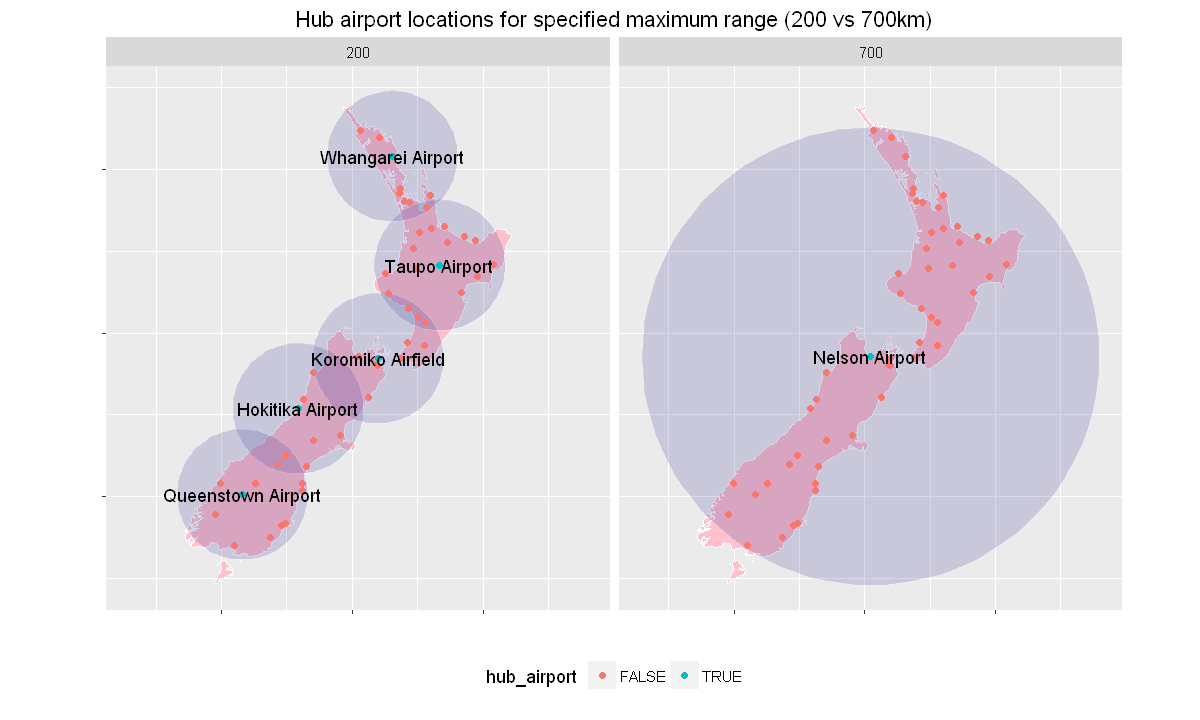

In [3]:
#fetch NZ map data and convert to NZTM coordinates
nz <- map_data("nz")
coordinates(nz) <- ~  long + lat
proj4string(nz) = CRS( "+init=epsg:4326")
nztm = as.data.frame(spTransform(nz, CRS( "+init=epsg:2193"))) %>%
  rename(northing=lat,easting=long)

#generate points for a circle to display
circleFun <- function(x, y, r, npoints = 100){
  tt <- seq(0,2*pi,length.out = npoints)
  xx <- x + r * cos(tt)
  yy <- y + r * sin(tt)
  return(data.frame(x = xx, y = yy))
}

#make range circle points for each hub airport
circles = results %>%
  filter(hub_airport==TRUE) %>%
  group_by(name,range) %>%
  do(circleFun(x=.$easting,y=.$northing,r=.$range * 1000))

#assemble the map plot layers here
map_plot = ggplot(nztm, aes(x = easting, y = northing)) +
  geom_polygon(aes(group = group),fill = "pink", colour = "white") + #add the map polygons
  geom_polygon(data = circles,aes(x,y,group=name),alpha=.2,fill=muted('blue')) + #add the range circles
  geom_point(data = results,aes(colour=hub_airport)) + #add the airport locations
  geom_text(data = results %>% filter(hub_airport==TRUE),aes(label=name)) + #label the hub airports
  facet_wrap(~range)+ #produce a chart for each range
  coord_equal() +
  #tweak the legend and axes to get more space
  theme(legend.position='bottom',
        axis.text.x=element_blank(),
        axis.text.y=element_blank()) +
  xlab('') + ylab('') +
  ggtitle('Hub airport locations for specified maximum range (200 vs 700km)')

print(map_plot)

#### 4. Results
At a 200km range, all airports can be reached from 5 hub
airports. There is minimal overlap between the 5 hub catchment areas,
which is a good indication that the algorithm is working as
intended by maximising coverage from the minimum number of locations. With a range of 700km only Nelson Airport is required to cover
all the mainland New Zealand airports, which is no surprise as Nelson
is [considered to be the geographical centre of NZ](https://en.wikipedia.org/wiki/Nelson,_New_Zealand#Geographical_centre_of_New_Zealand).


## Summary

Minimum Set Cover optimisation is one of the useful tools in my set of
[Data Science techniques](http://datascience.mwhglobal.com/) that can
be deployed across a range of settings, as shown by the examples
above.

If you would like help with a Set Cover optimisation or have a problem that
requires input from a Data Scientist, then please [send me an email](mailto:selwyn.b.mccracken@mwhglobal.com?subject=Optimisation help).
